#  Procesamiento de Señales de Audio Mediante Analisis de Fourier

Estudiantes: Christian Loja, Martín Vinces, Erick Ramón.

En este archivo se realizará una serie de actividades o ejemplos de la aplicación del análisis de Fourier para el tratamiento de señales de audio. En específico se aplicarán filtros pasa altos, pasa bajos, pasa banda y un par de efectos de reverberación.

Para facilitar el trabajo se han implementado una serie de librerías que contienen herramientas dirigidas al tratamiento y visualización de señales. Las herramientas necesarias para el análisis de Fourier se obtienen mediante la aplicación de la librería Scipy, así mismo, los filtros h[n] se diseñarán mediante la herramienta "firwin" de esta misma librería. Estas respuestas al impulso se usarán para calcular una respuesta en frecuencia y aplicar la propiedad de convolución de la Transformada de Fourier.

In [1]:
# Librerias usadas
import numpy as np
import pandas as pd
import scipy.fftpack as fourier
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.signal import firwin, freqz, spectrogram
from glob import glob

# Cargar la ubicación de la señal de audio de entrada
audio_file = glob('C:/Users/Christian/Documents/U_Cuenca/Sistemas L y Señales/Trabajo_Convolucion/ambient-piano.mp3')

In [2]:
# Cargar el archivo de audio en un array "audio" y extraer su sample rate en una variable "sr"
audio_in, sr = librosa.load(audio_file[0])

print(f'Datos audio de entrada: {audio_in[:10]}') # Primeros 10 datos de la señal de audio
print(f'Shape audio de entrada: {audio_in.shape}') # Tamaño del array de la señal de audio
print(f'Sample Rate: {sr}') # Sample rate de la señal de audio

Datos audio de entrada: [-6.8212103e-13 -4.5474735e-13  4.8316906e-13  1.5916157e-12
 -3.9790393e-13  2.7284841e-12 -6.8212103e-13 -1.0231815e-12
 -2.7284841e-12 -9.6633812e-13]
Shape audio de entrada: (232128,)
Sample Rate: 22050


El siguiente código se encarga de mostrar la distribución de los datos que componen el audio en el dominio del tiempo. Además, proporciona una visión didáctica de las frecuencias que componen el audio en forma de espectrograma.

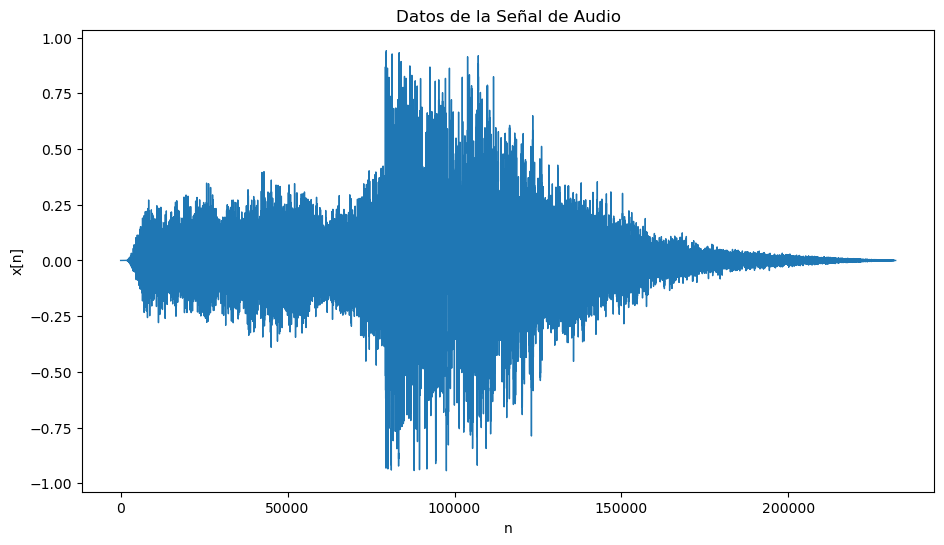

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio')

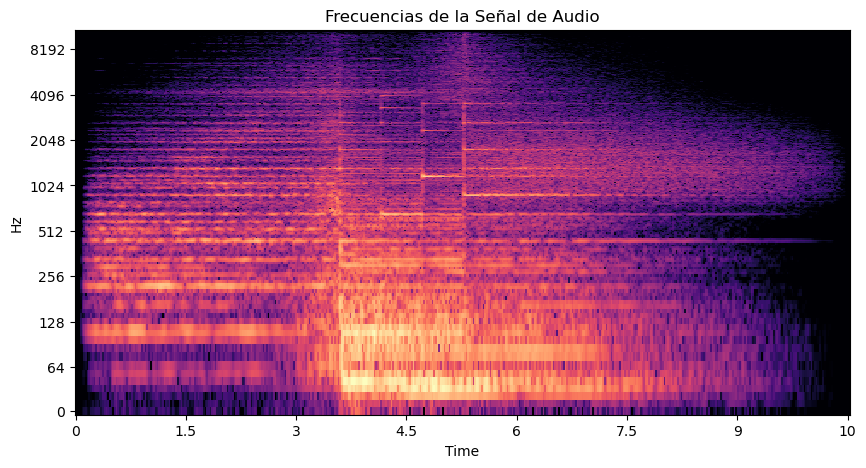

In [3]:
# Graficar datos en el tiempo de la señal de audio
pd.Series(audio_in).plot(figsize=(11, 6), lw=1, title='Datos de la Señal de Audio')
plt.xlabel('n')
plt.ylabel('x[n]')
plt.show()

# Graficar el espectro de frecuencias de la señal de audio
TF_audio = librosa.stft(audio_in)
Amp_audio_db = librosa.amplitude_to_db(abs(TF_audio), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio')

El siguiente código muestra la forma en que se aplica la transformada de Fourier sobre la señal de audio usando la función "fourier.fft" de la librería Scipy.

En este bloque de código también se genera una gráfica de la magnitud de la transformada de Fourier de la señal de audio con respecto a la frecuencia en Hz. Esta gráfica es de utilidad para visualizar la simetría de la transformada de Fourier y para, después, comprender cómo se aplican los filtros y efectos sobre el espectro de frecuencias del audio.

X(jw)= [-28.421082  -0.j        12.02609  +12.886331j  -3.1719122 -7.024541j ...
  -8.2631645 -8.609078j  -3.1719122 +7.024541j  12.02609  -12.886331j]
X(jw)= 232128


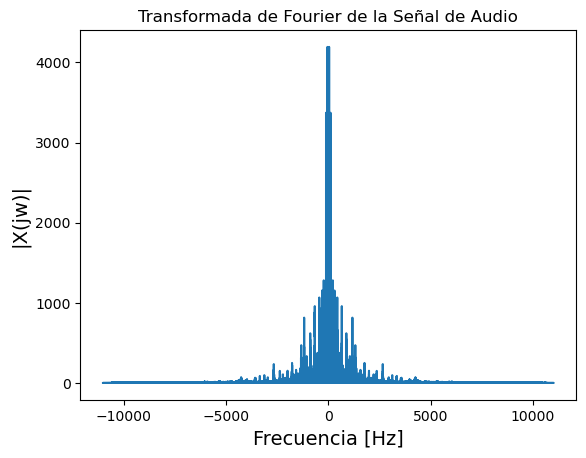

In [4]:
# Cálculo de la TF de la señal de audio de entrada
TF_entrada = fourier.fft(audio_in)
print(f'X(jw)= {TF_entrada}') # Primeros valores de la TF del audio
print(f'X(jw)= {len(TF_entrada)}') # Primeros valores de la TF del audio

# Cálculo de la magnitud de la TF de la señal de audio
Mag_TF_in = abs(TF_entrada)

# Generación de un vector de frecuencias
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la TF de la señal de audio
plt.plot(vect_frec, Mag_TF_in)
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.title('Transformada de Fourier de la Señal de Audio')
plt.ylabel('|X(jw)|', fontsize='14')
plt.show()

Anteriormente se mostró la magnitud de la transformada de Fourier, por lo que puede ser interesante observar los ángulos de fase de la señal. Esto se logra con el código a continuación.

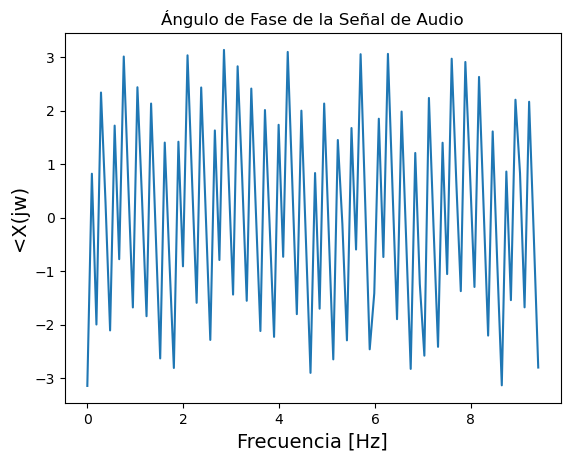

In [5]:
# Cálculo del vector de ángulos de Fase
ang = np.angle(TF_entrada)

# Graficar la TF de la señal de audio
plt.plot(vect_frec[0:100], ang[0:100])
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.title('Ángulo de Fase de la Señal de Audio')
plt.ylabel('<X(jw)', fontsize='14')
plt.show()

En la gráfica de la magnitud de la Transformada de Fourier mostrada previamente, se veía que existen componentes de magnitud correspondientes a frecuencias negativas. Estos datos no tienen sentido para el procesamiento de las señales de audio ya que no podemos reproducir frecuencias negativas. Por ende, durante el tratamiento de las señales se tomará en cuenta únicamente la zona de frecuencias positivas de la transformada de Fourier.

A continuación se muestra como luce la zona de interés del espectro de frecuencias de la señal de audio.

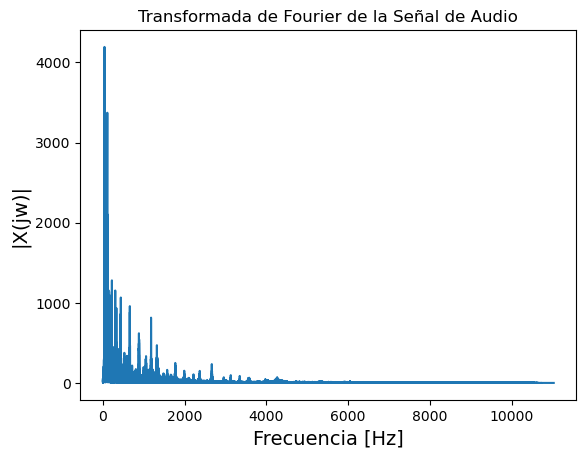

In [6]:
Mag_TF_in = Mag_TF_in[0:len(Mag_TF_in)//2]

# Generación de un vector de frecuencias
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)[:len(audio_in)//2]

# Graficar la TF de la señal de audio
plt.plot(vect_frec, Mag_TF_in)
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.title('Transformada de Fourier de la Señal de Audio')
plt.ylabel('|X(jw)|', fontsize='14')
plt.show()

La siguiente línea de código nos permite reproducir la señal de audio cargada:

In [7]:
ipd.Audio(audio_in, rate=sr) # Reproducir el audio cargado

## Aplicación de filtros (Pasa Banda, Pasa Bajos, Pasa Altos)

Para obtener los valores de las respuestas al impulso necesarias en la aplicación de cada filtro se utilizará la herramienta firwin (generadora de filtros FIR) de la librería Scipy. Esta función necesita un conjunto de datos sobre la señal de entrada que se quiere filtrar, los cuales son: numtaps o la cantidad de coeficientes o valores que tendrá h[n], cutoff es la frecuencia de corte para el filtro, window es el método de ventanas de filtro que se aplicará (en este caso se usará Hamming en todos los filtros), pass_zero define si el filtro pasa por la frecuencia 0 y, por último, fs que hace referencia al sample rate de la señal de entrada.

Para que el filtro funcione de manera eficiente con la señal de entrada es necesario definir todos sus parámetros correctamente.

Esta respuesta al impulso es muy importante, ya que, a partir de su transformada de Fourier se encontrará la respuesta en frecuencia que caracteriza a cada filtro. Con este nuevo conjunto de dato es posible filtrar la señal de audio realizando una multiplicación en frecuencia X(jw)H(jw) en lugar de aplicar convolución en el dominio del tiempo x(t)*h(t).

### Filtro Pasa Bajo
Un filtro pasa bajo funciona de tal manera que en la salida del sistema se tienen únicamente las frecuencias que están por debajo de una frecuencia de corte definida, es decir, si se diseña un filtro pasa bajos con frecuencia de corte en 300Hz, entonces, las frecuencias que llegarán a la salida son las que están entre 0 y 300Hz.

A continuación se muestra el diseño del filtro FIR para obtener un filtro pasa bajos con frecuencia de corte de 300Hz.

h[n]= [1.23595157e-07 1.07666743e-07 9.09517218e-08 ... 9.09517218e-08
 1.07666743e-07 1.23595157e-07]


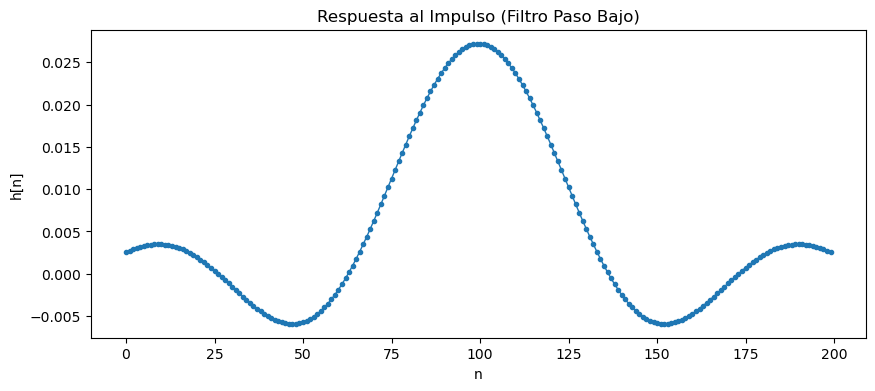

In [8]:
# Diseño de filtro FIR
frec_corte = 300 # Se define una frecuencia de corte
h_bajo = firwin(numtaps=232128, cutoff=frec_corte, window='hamming', pass_zero=True, fs=22050)

print(f'h[n]= {h_bajo}') # Primeros valores de la respuesta al impulso

#Graficar los valores de la respuesta al impulso
pd.Series(h_bajo[115964:116164]).plot(figsize=(10, 4), lw=1, marker='.', title='Respuesta al Impulso (Filtro Paso Bajo)')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.show()

Con el código anterior también se genera una gráfica de la respuesta al impulso del filtro pasa bajas. Con la curva dibujada se ve que la herramienta "firwin" ha generado un sinc.

El código a continuación calcula la respuesta en frecuencia del sinc anterior. Además, para verificar si la respuesta en frecuencia es un filtro pasa bajas se realiza una gráfica de su magnitud con respecto a la frecuencia.

H[jw]= [ 1.        -0.00000000e+00j -1.00000823-1.35339921e-05j
  1.        +2.70677613e-05j ... -1.00000823+4.06019762e-05j
  1.        -2.70677613e-05j -1.00000823+1.35339921e-05j]


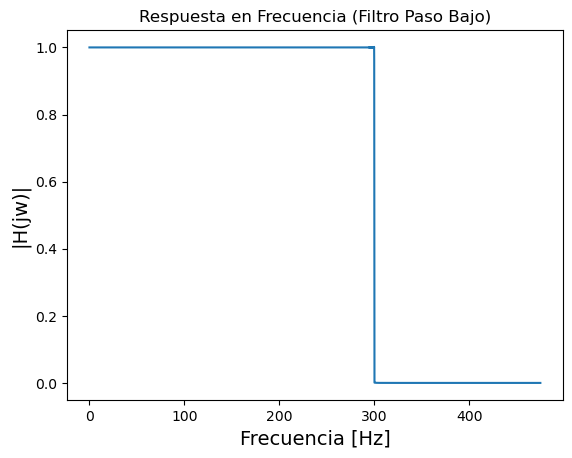

In [9]:
# Obtención de la respuesta en Frecuencia
H_jw = fourier.fft(h_bajo)

print(f'H[jw]= {H_jw}') # Algunos valores de la respuesta en Frecuencia

# Cálculo de la magnitud de la TF
Mag_H_jw = abs(H_jw)
Mag_H_jw = Mag_H_jw[0:len(h_bajo)//2]

# Generación de un vector de frecuencias
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)[:len(audio_in)//2]

# Graficar los valores de la respuesta en Frecuencia
plt.plot(vect_frec[0:5000], Mag_H_jw[0:5000])
plt.title('Respuesta en Frecuencia (Filtro Paso Bajo)')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Como se ve en la gráfica anterior, la respuesta en frecuencia del filtro FIR corresponde a un filtro pasa bajas con frecuencia de corte en 300Hz.

Con el bloque de código a continuación se realiza la multiplicación en frecuencia para aplicar el filtro pasa bajas al espectro de la señal de audio.

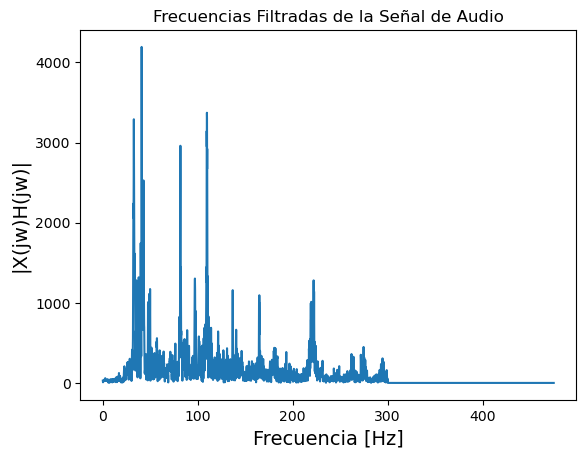

In [10]:
# Multiplicación en frecuencia para aplicar el filtro paso bajo
multiplicacion = TF_entrada*H_jw

# Cálculo de la magnitud del resultado de la multiplicación
Mag_mult = abs(multiplicacion)

# Generación del vector de frecuencias
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar los valores de la señal filtrada
plt.plot(vect_frec[0:5000], Mag_mult[0:5000])
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

La gráfica anterior muestra el resultado de la multiplicación en frecuencia. Si se analizan los componentes de frecuencia existentes en el resultado se ve que estos son diferentes de cero únicamente en el rango de 0 a 300Hz, en cambio, las frecuencias mayores a 300Hz han sido eliminadas por completo. Esto sucede debido a la aplicación del filtro pasa bajas en el dominio de la frecuencia.

Como se dijo anteriormente, el espectro de frecuencias es simétrico, por lo que debemos considerar únicamente los valores con frecuencias positivas. En el bloque de código a continuación, se extraen únicamente los componentes de frecuencias relacionados a frecuencias positivas y se eliminan las de frecuencias negativas. Además, se representa gráficamente a los componentes de frecuencia resultantes del filtrado.

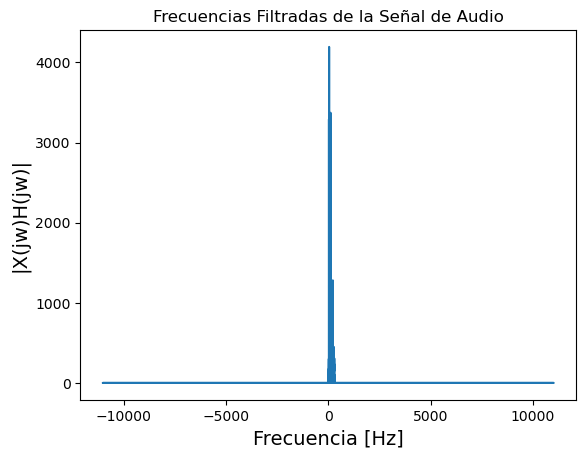

In [11]:
# Tomamos solamente la mitad de los datos para reconstruir el audio
Mag_fil = multiplicacion

for i in range(len(h_bajo)//2, len(h_bajo)):
    Mag_fil[i] = 0

reconstruir = Mag_fil
Mag_fil = abs(Mag_fil)

vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar los valores de la señal de audio filtrada
plt.plot(vect_frec, Mag_fil)
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

Con el siguiente código se aplica la transformada inversa de Fourier a los valores resultantes del filtrado de la señal. La herramienta de Scipy "fourier.ifft" para calcular la transformada inversa de Fourier aplica un desplazamiento en el tiempo a la señal resultante en el dominio del tiempo, esto debido a que la mitad del vector con el espectro de frecuencia está rellenado con ceros después de eliminar los datos con frecuencias negativas. La eliminación de la simetría en el vector hace que la herramienta "fourier.ifft" no sepa cómo está centrada la señal dada como argumento, lo que causa el problema descrito.

Este desplazamiento indeseado en el tiempo se elimina re-ordenando los datos de la señal filtrada en el dominio del tiempo de la siguiente forma:

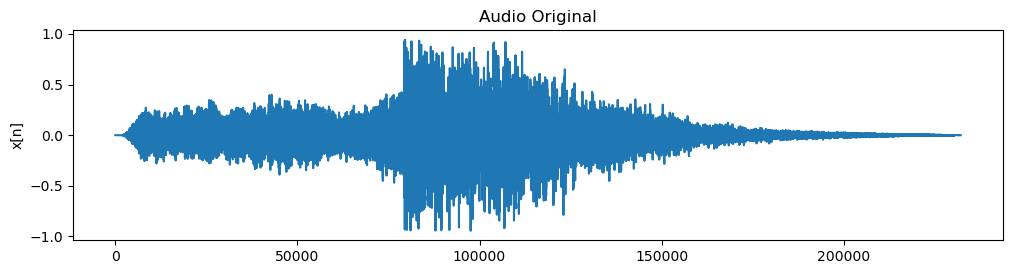

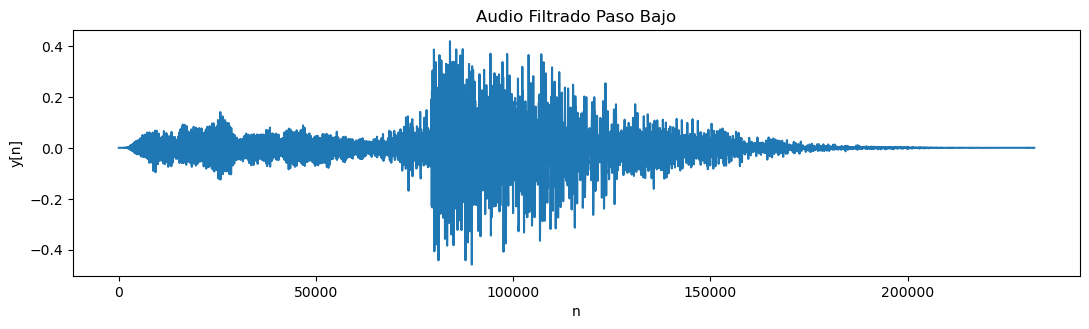

In [12]:
# Aplicación de la Transformada Inversa de Fourier
reconstruir = fourier.ifft(reconstruir)

# Ordenar los datos resultantes en el dominio del tiempo
ord1 = reconstruir[len(h_bajo)//2: len(h_bajo)]
ord2 = reconstruir[0: len(h_bajo)//2]

# Señal corregida, proceso de filtrado finalizado
ordenado = np.concatenate((ord1, ord2))

# Graficar la señal de entrada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_in)
plt.ylabel('x[n]')
plt.title('Audio Original')

# Graficar la señal filtrada
plt.figure(figsize=(11, 6))
plt.subplot(2, 1, 2)
plt.plot(np.real(ordenado))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title('Audio Filtrado Paso Bajo')
plt.tight_layout()
plt.show()

Las imágenes presentadas previamente (generadas con el código anterior) muestran la distribución y amplitud de los datos de la señal de audio original y de la señal de audio filtrada. En las gráficas se ven notables diferencias en la amplitud de los datos de las señales.

Las diferencias en cuanto a la aplicación del filtro pasa bajos no es sencilla de observar con el par de imágenes anterior. Para apreciar de forma clara los cambios que se han hecho en la señal de audio se ha desarrollado el siguiente código que dibuja un espectrograma de la señal de audio filtrada.

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio Filtrado Paso Bajo')

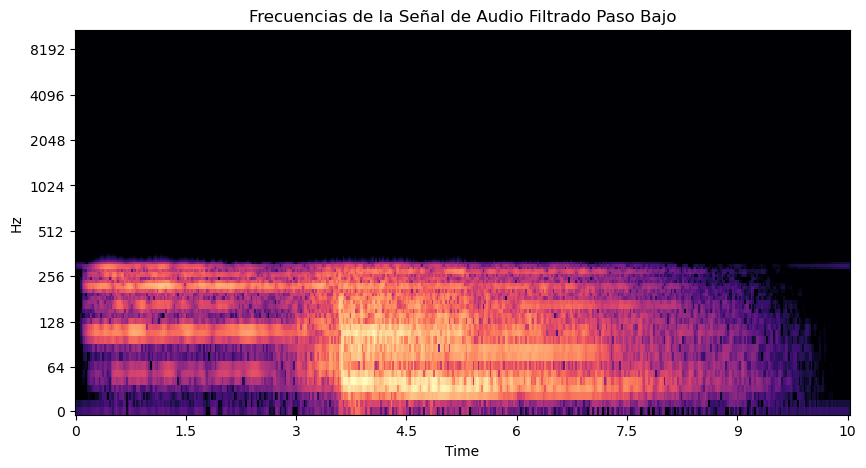

In [13]:
# Graficar el espectro de frecuencias de la señal de audio filtrada
TF_audio1 = librosa.stft(np.real(ordenado))
Amp_audio_db1 = librosa.amplitude_to_db(abs(TF_audio1), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db1, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio Filtrado Paso Bajo')

En el espectrograma obtenido se ve claramente que las frecuencias por encima de aproximadamente los 300Hz son inexistentes. Esta representación muestra el comportamiento de un filtro paso bajos.

El siguiente código permite reproducir el audio de la señal resultante:

In [14]:
ipd.Audio(np.real(ordenado), rate=sr) #Reproducir el audio resultante

### Filtro Pasa Banda
Un filtro pasa banda es un filtro que solamente permite pasar a la salida las frecuencias que están contenidas en un intervalo definido de frecuencias. En este caso, usando la función firwin de la librería Scipy se generará un filtro FIR cuya respuesta en frecuencia nos permita extraer solamente las frecuencias del audio que estén dentro del intervalo definido.

A continuación se muestra el diseño del filtro FIR para obtener un filtro pasa banda con frecuencia de corte de 300Hz a 600Hz.

h[n]= [8.06419818e-08 7.99562765e-08 7.45857968e-08 ... 7.45857968e-08
 7.99562765e-08 8.06419818e-08]


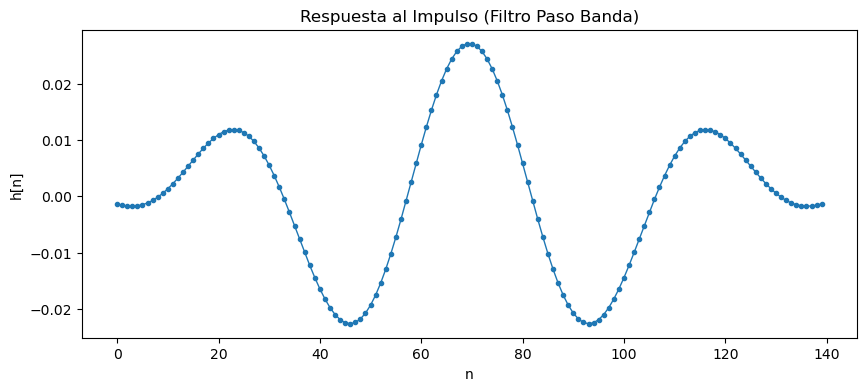

In [15]:
# Diseño del filtro FIR paso banda
frec_corte_a = 300 # Frecuencia de corte inicio del intervalo
frec_corte_b = 600 # Frecuencia de corte final del intervalo
h_banda = firwin(numtaps=232128, cutoff=[frec_corte_a, frec_corte_b], window='hamming', pass_zero=False, fs=22050)

print(f'h[n]= {h_banda}') # Primeros valores de la respuesta al impulso

# Graficar la respuesta al impulso del filtro paso banda
pd.Series(h_banda[115994:116134]).plot(figsize=(10, 4), lw=1, marker='.', title='Respuesta al Impulso (Filtro Paso Banda)')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.show()

Con el código anterior también se genera una gráfica de la respuesta al impulso del filtro pasa banda. Con la curva dibujada se ve que la herramienta "firwin" nuevamente ha generado un sinc, sin embargo, su forma y amplitud es diferente al FIR para el filtro pasa bajos.

El código a continuación calcula la respuesta en frecuencia del sinc anterior. Además, para verificar si la respuesta en frecuencia es un filtro pasa banda se realiza una gráfica de su magnitud con respecto a la frecuencia.

H[jw]= [3.38399879e-06-0.00000000e+00j 3.38399912e-06+4.57986431e-11j
 3.38400028e-06+9.15973027e-11j ... 3.38400232e-06-1.37396050e-10j
 3.38400028e-06-9.15973027e-11j 3.38399912e-06-4.57986431e-11j]
H[jw]= [ 0.          0.09499069  0.18998139 ... -0.28497208 -0.18998139
 -0.09499069]


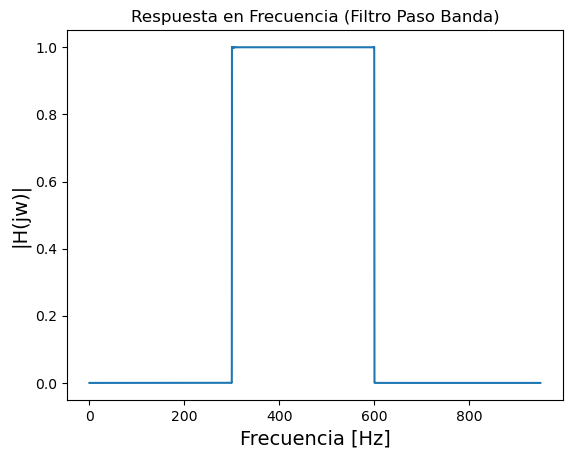

In [16]:
# Cálculo de la respuesta en frecuencia del filtro paso banda
H_jw2 = fourier.fft(h_banda)

print(f'H[jw]= {H_jw2}') # Primeros valores de la respuesta al impulso

# Cálculo de la magnitud de TF de la respuesta en frecuencia
Mag_H_jw2 = abs(H_jw2)

# Generación del vector de frecuencias
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)
print(f'H[jw]= {vect_frec}') # Primeros valores de la respuesta al impulso


# Graficar la respuesta en frecuencia del filtro
plt.plot(vect_frec[0:10000], Mag_H_jw2[0:10000])
plt.title('Respuesta en Frecuencia (Filtro Paso Banda)')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Como se ve en la gráfica anterior, la respuesta en frecuencia del filtro FIR corresponde a un filtro pasa banda que permite el paso de frecuencias entre 300Hz y 600Hz.

Con el bloque de código a continuación se realiza la multiplicación en frecuencia para aplicar el filtro pasa banda al espectro de la señal de audio.

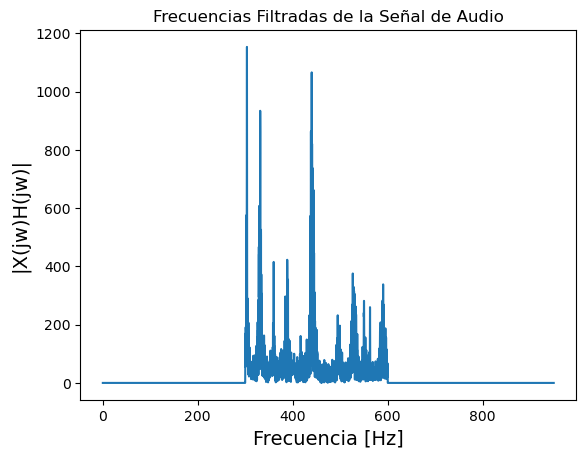

In [17]:
# Multiplicación en frecuencia para aplicar el filtro
multiplicacion2 = TF_entrada*H_jw2

Mag_mult2 = abs(multiplicacion2)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal filtrada
plt.plot(vect_frec[0:10000], Mag_mult2[0:10000])
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

La gráfica anterior muestra el resultado de la multiplicación en frecuencia. Si se analizan los componentes de frecuencia existentes en el resultado se ve que estos son diferentes de cero únicamente en el rango de 300Hz a 600Hz, en cambio, las demás frecuencias han sido eliminadas por completo. Esto sucede debido a la aplicación del filtro pasa banda en el dominio de la frecuencia.

Como se dijo anteriormente, el espectro de frecuencias es simétrico, por lo que debemos considerar únicamente los valores con frecuencias positivas. En el bloque de código a continuación, se extraen únicamente los componentes de frecuencias relacionados a frecuencias positivas y se eliminan las de frecuencias negativas. Además, se representa gráficamente a los componentes de frecuencia resultantes del filtrado.

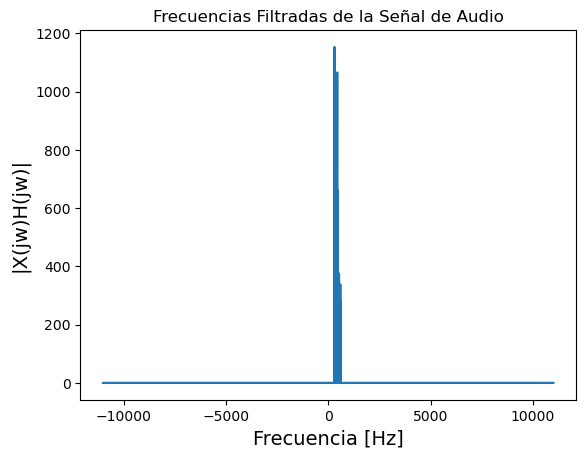

In [18]:
# Tomamos la mitad de los valores para reconstruir el audio
Mag_fil2 = multiplicacion2

for i in range(len(h_banda)//2, len(h_banda)):
    Mag_fil2[i] = 0

reconstruir2 = Mag_fil2
Mag_fil2 = abs(Mag_fil2)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar valores de la señal de audio filtrada
plt.plot(vect_frec, Mag_fil2)
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

Con el siguiente código se aplica la transformada inversa de Fourier a los valores resultantes del filtrado de la señal. En este caso nuevamente existe el problema del desplazamiento indeseado en el tiempo al momento de aplicar la función "fourier.ifft".

Este desplazamiento en el tiempo se elimina re-ordenando los datos de la señal filtrada en el dominio del tiempo de la siguiente forma:

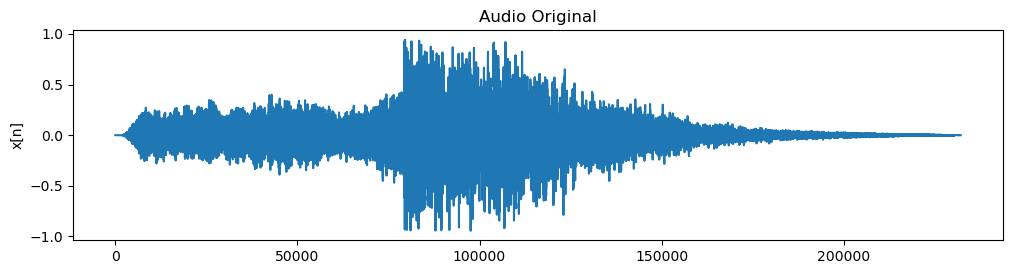

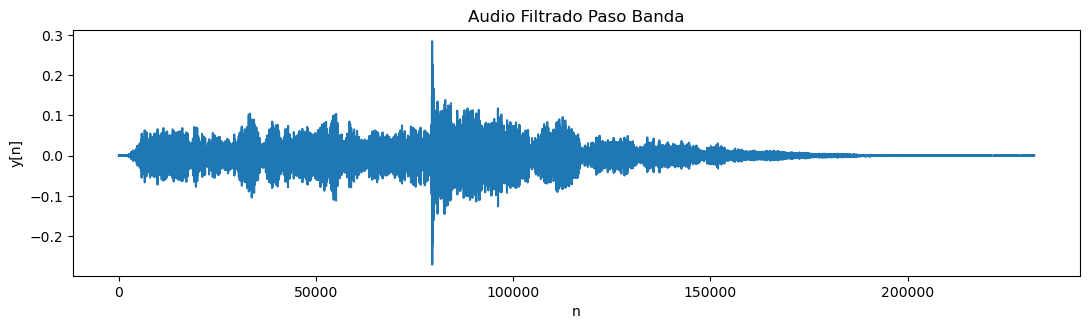

In [19]:
# Aplicación de la Transformada Inversa de Fourier
reconstruir2 = fourier.ifft(reconstruir2)

# Ordenar los datos resultantes
orda = reconstruir2[len(h_banda)//2: len(h_banda)]
ordb = reconstruir2[0: len(h_banda)//2]
ordenado2 = np.concatenate((orda, ordb))

# Graficar la señal de entrada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_in)
plt.ylabel('x[n]')
plt.title('Audio Original')

# Graficar la señal filtrada
plt.figure(figsize=(11, 6))
plt.subplot(2, 1, 2)
plt.plot(np.real(ordenado2))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title('Audio Filtrado Paso Banda')
plt.tight_layout()
plt.show()

Las imágenes presentadas previamente (generadas con el código anterior) muestran la distribución y amplitud de los datos de la señal de audio original y de la señal de audio filtrada. En las gráficas se ven notables diferencias en la amplitud y distribución de los datos de las señales.

Las diferencias en cuanto a la aplicación del filtro pasa banda no es sencilla de observar con el par de imágenes anterior. Para apreciar de forma clara los cambios que se han hecho en la señal de audio se ha desarrollado el siguiente código que dibuja un espectrograma de la señal de audio filtrada.

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio Filtrado Paso Banda')

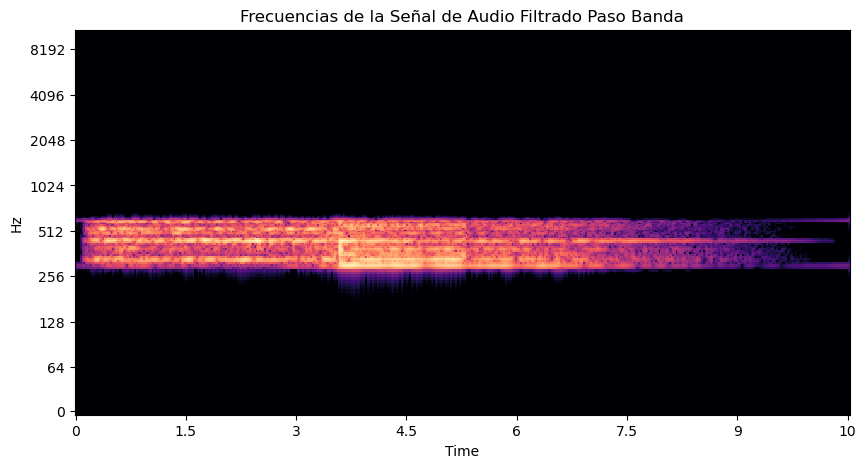

In [20]:
# Graficar el espectro de frecuencias de la señal de audio filtrada
TF_audio2 = librosa.stft(np.real(ordenado2))
Amp_audio_db2 = librosa.amplitude_to_db(abs(TF_audio2), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db2, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio Filtrado Paso Banda')

En el espectrograma obtenido se ve claramente que las únicas frecuencias existentes se encuentran aproximadamente entre los 300Hz y 600Hz, todas las demás frecuencias han sido filtradas. Esta representación muestra el comportamiento de un filtro paso banda.

El siguiente código permite reproducir el audio de la señal resultante:

In [21]:
ipd.Audio(np.real(ordenado2), rate=sr) #Reproducir el audio resultante

### Filtro Pasa Altos

Un filtro pasa altos permite que a la salida lleguen únicamente los componentes de frecuencias que están por encima de una frecuencia de corte definida.

A continuación, se muestra la generación de una respuesta al impulso que permitirá eliminar las frecuencias de la señal de audio de entrada que estén por debajo de los 320Hz.

h[n]= [-4.19407797e-08 -6.61626336e-08 -8.95262700e-08 ... -8.95262700e-08
 -6.61626336e-08 -4.19407797e-08]


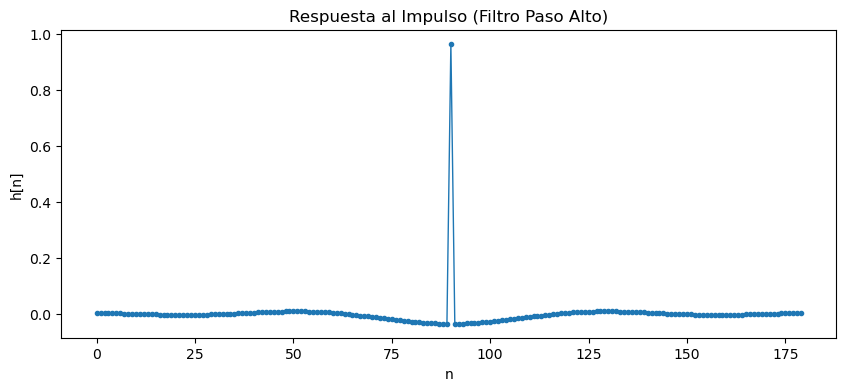

In [22]:
# Diseño del filtro FIR paso alto
frec_corte2 = 400 # Se define una frecuencia de corte
h_alto = firwin(numtaps=232129, cutoff=frec_corte2, window='hamming', pass_zero=False, fs=22050)

print(f'h[n]= {h_alto}') # Primeros valores de la respuesta al impulso

# Graficar la respuesta al impulso del filtro
pd.Series(h_alto[115974:116154]).plot(figsize=(10, 4), lw=1, marker='.', title='Respuesta al Impulso (Filtro Paso Alto)')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.show()

Con el código anterior también se genera una gráfica de la respuesta al impulso del filtro pasa altos. Con la curva dibujada se ve que la herramienta "firwin" ha generado datos parecidos a una función sinc pero con solamente un valor con amplitud cercano a uno en el medio de la señal. Los demás valores del filtro oscilan con una amplitud muy cercana a cero.

El código a continuación calcula la respuesta en frecuencia del filtro FIR anterior. Además, para verificar si la respuesta en frecuencia es un filtro pasa altas se realiza una gráfica de su magnitud con respecto a la frecuencia.

H[jw]= [-3.81662572e-06-0.00000000e+00j -3.81662594e-06-5.16531451e-11j
 -3.81662661e-06-1.03307125e-10j ... -3.81662768e-06+1.54961351e-10j
 -3.81662661e-06+1.03307125e-10j -3.81662594e-06+5.16531451e-11j]


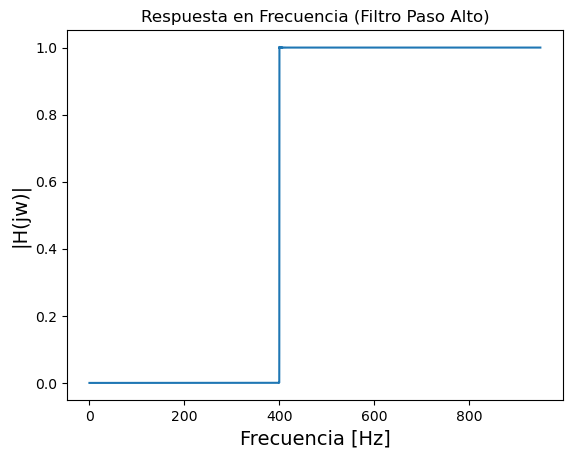

In [23]:
# Cálculo de la respuesta en frecuencia
H_jw3 = fourier.fft(h_alto)

print(f'H[jw]= {H_jw3}') # Primeros valores de la respuesta al impulso

Mag_H_jw3 = abs(H_jw3)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la respuesta en frecuencia del filtro
plt.plot(vect_frec[0:10000], Mag_H_jw3[0:10000])
plt.title('Respuesta en Frecuencia (Filtro Paso Alto)')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Como se ve en la gráfica anterior, la respuesta en frecuencia del filtro FIR corresponde a un filtro pasa altas que permite el paso de frecuencias que estén por encima de los 400Hz.

Con el bloque de código a continuación se realiza la multiplicación en frecuencia para aplicar el filtro pasa altas al espectro de la señal de audio.

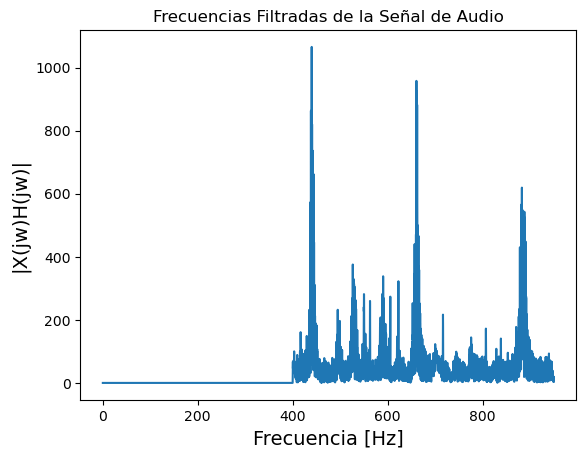

In [24]:
# Multiplicación en frecuencia para aplicar el filtro
multiplicacion3 = np.append(TF_entrada,0)*H_jw3

Mag_mult3 = abs(multiplicacion3)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal filtrada
plt.plot(vect_frec[0:10000], Mag_mult3[0:10000])
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

La gráfica anterior muestra el resultado de la multiplicación en frecuencia. Si se analizan los componentes de frecuencia existentes en el resultado se ve que estos son diferentes de cero son únicamente los que están por encima de los 400Hz, en cambio, las demás frecuencias han sido eliminadas por completo. Esto sucede debido a la aplicación del filtro pasa altas en el dominio de la frecuencia.

Como se dijo anteriormente, el espectro de frecuencias es simétrico, por lo que debemos considerar únicamente los valores con frecuencias positivas. En el bloque de código a continuación, se extraen únicamente los componentes de frecuencias relacionados a frecuencias positivas y se eliminan las de frecuencias negativas. Además, nuevamente se representa gráficamente a los componentes de frecuencia resultantes del filtrado desde una perspectiva que abarque más frecuencias.

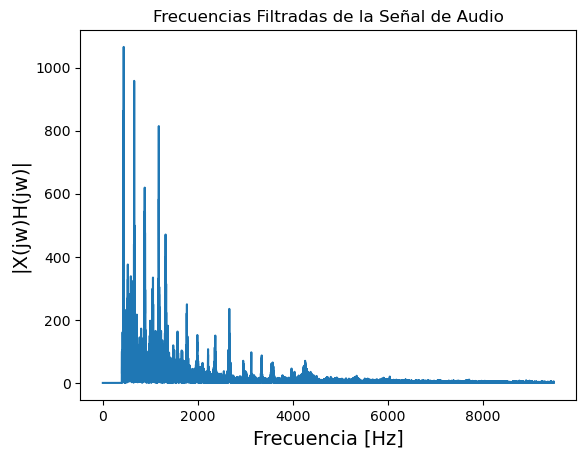

In [25]:
# Tomamos la mitad de los datos para reconstruir el audio
Mag_fil3 = multiplicacion3

for i in range(len(h_alto)//2, len(h_alto)):
    Mag_fil3[i] = 0

reconstruir3 = Mag_fil3
vect_frec = fourier.fftfreq(len(audio_in)+1, 1/sr)

# Graficar la señal de audio filtrada
plt.plot(vect_frec[0:100000], abs(Mag_fil3)[0:100000])
plt.title('Frecuencias Filtradas de la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

Con el siguiente código se aplica la transformada inversa de Fourier a los valores resultantes del filtrado de la señal. En este caso nuevamente existe el problema del desplazamiento indeseado en el tiempo al momento de aplicar la función "fourier.ifft".

Este desplazamiento en el tiempo se elimina re-ordenando los datos de la señal filtrada en el dominio del tiempo de la siguiente forma:

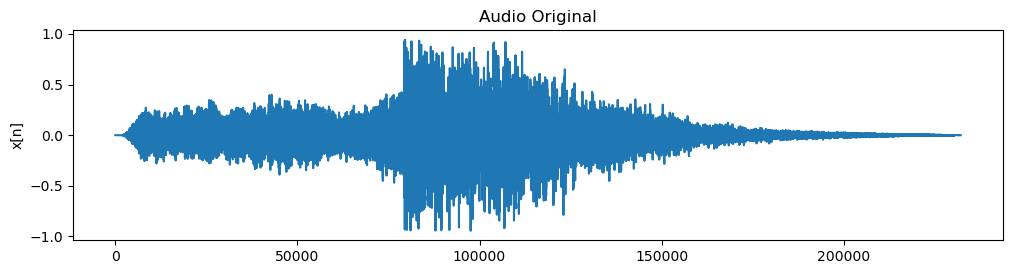

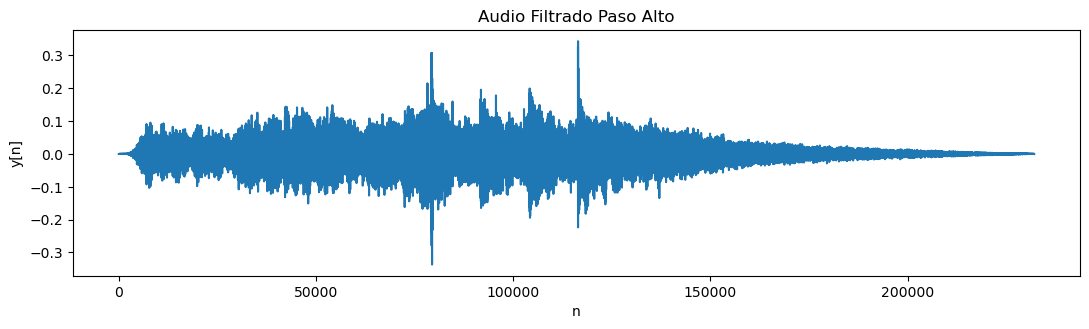

In [26]:
# Aplicación de la Transformada Inversa de Fourier
reconstruir3 = fourier.ifft(reconstruir3)

ordx = reconstruir3[len(h_alto)//2: len(h_alto)]
ordy = reconstruir3[0: len(h_alto)//2]
ordenado3 = np.concatenate((ordx, ordy))

# Graficar la señal de entrada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_in)
plt.ylabel('x[n]')
plt.title('Audio Original')

# Graficar la señal filtrada
plt.figure(figsize=(11, 6))
plt.subplot(2, 1, 2)
plt.plot(np.real(ordenado3))
plt.xlabel('n')
plt.ylabel('y[n]')
plt.title('Audio Filtrado Paso Alto')
plt.tight_layout()
plt.show()

Las imágenes presentadas previamente (generadas con el código anterior) muestran la distribución y amplitud de los datos de la señal de audio original y de la señal de audio filtrada. En las gráficas se ven notables diferencias en la amplitud y distribución de los datos de las señales.

Las diferencias en cuanto a la aplicación del filtro pasa altas no es sencilla de observar con el par de imágenes anterior. Para apreciar de forma clara los cambios que se han hecho en la señal de audio se ha desarrollado el siguiente código que dibuja un espectrograma de la señal de audio filtrada.

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio Filtrado Paso Alto')

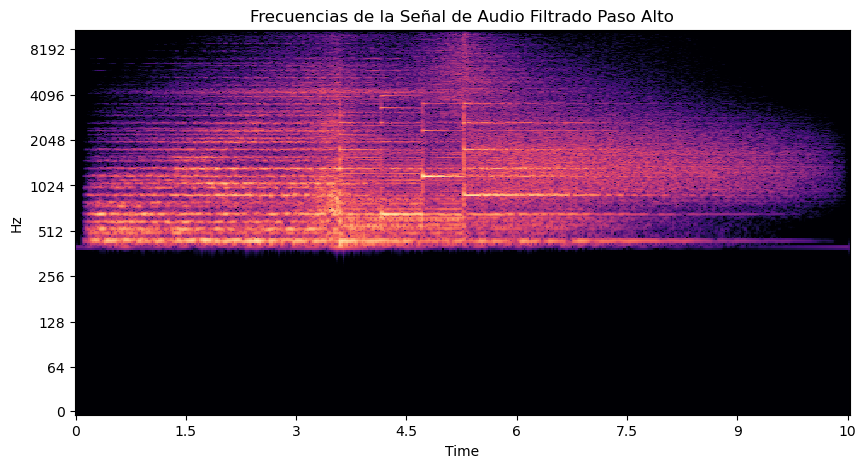

In [27]:
# Graficar el espectro de frecuencias de la señal de audio filtrada
TF_audio3 = librosa.stft(np.real(ordenado3))
Amp_audio_db3 = librosa.amplitude_to_db(abs(TF_audio3), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db3, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio Filtrado Paso Alto')

En el espectrograma obtenido se ve claramente que las únicas frecuencias existentes se encuentran aproximadamente desde los 400Hz en adelante, todas las demás frecuencias han sido filtradas. Esta representación muestra el comportamiento de un filtro pasa altas.

El siguiente código permite reproducir el audio de la señal resultante:

In [28]:
ipd.Audio(np.real(ordenado3), rate=sr) #Reproducir el audio resultante

## Efecto de Reverberación 

El efecto de reverberación se obtiene al mezclar dos señales (mediante convolución o análisis de Fourier) de audio y obtener una sola con las características de ambas señales. La primera señal necesaria corresponde al audio que se quiere modificar, por otro lado, la segunda señal es la respuesta al impulso obtenida por grabaciones en un espacio que genere reverberación por si solo.

1. La primera respuesta al impulso que se usará corresponde a una señal que comienza en 1 y va decayendo lentamente hacia cero.

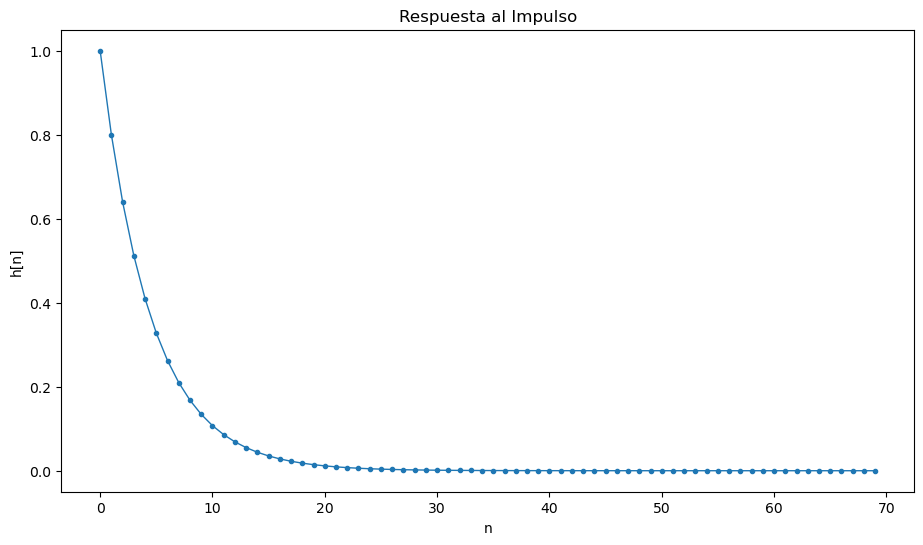

In [29]:
cant_coef = 232128  # Cantidad de términos en h[n]
h_rev = np.zeros(cant_coef)

h_rev[0] = 1.0  # Valor inicial o en h[n]=0
atenuar = 0.8  # Factor de atenuación de la reverberación

# Generación de la respuesta al impulso del efecto
for i in range(1, cant_coef):
    h_rev[i] = atenuar * h_rev[i - 1]
    
# Graficar la respuesta al impulso
pd.Series(h_rev[0:70]).plot(figsize=(11, 6), lw=1, marker='.', title='Respuesta al Impulso')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.show()

Con el código anterior también se genera una gráfica de la respuesta al impulso del efecto de reverberación. Con la curva dibujada se ve que la respuesta al impulso comienza en un valor máximo igual a 1 y, a medida que crece el valor de n la amplitud de la señal tiende a cero.

El código a continuación calcula la respuesta en frecuencia de la señal anterior y la representa gráficamente.

H[jw]= [5.        -0.j         4.99999993-0.00054136j 4.99999974-0.00108271j ...
 4.99999941+0.00162407j 4.99999974+0.00108271j 4.99999993+0.00054136j]


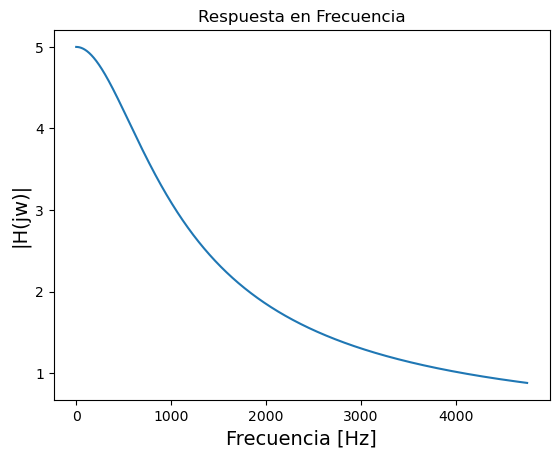

In [30]:
# Cálculo de la respuesta en frecuencia del efecto
H_jw4 = fourier.fft(h_rev)

print(f'H[jw]= {H_jw4}') # Primeros valores de la respuesta al impulso

# Cálculo de la magnitud de la TF
Mag_H_jw4 = abs(H_jw4)

vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la respuesta en frecuencia del efecto
plt.plot(vect_frec[0:50000], Mag_H_jw4[0:50000])
plt.title('Respuesta en Frecuencia')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Como se ve en la gráfica anterior, la respuesta en frecuencia del efecto de reverberación es similar a un filtro, puesto que, acentúa las frecuencias que están entre 0 y 3KHz y, por otro lado, atenúa las frecuencias por encima de los 3KHz. Este comportamiento de la respuesta en frecuencia caracteriza al efecto.

Con el bloque de código a continuación se realiza la multiplicación en frecuencia para aplicar el efecto de reverberación al espectro de la señal de audio.

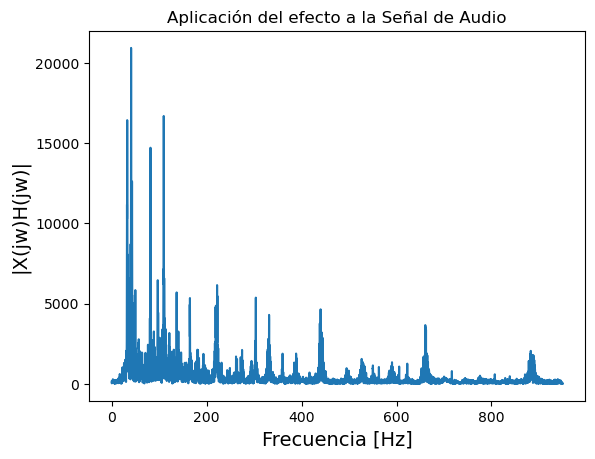

In [31]:
# Multiplicación en frecuencia para aplicar el efecto
multiplicacion4 = TF_entrada*H_jw4

Mag_mult4 = abs(multiplicacion4)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal mezclada con el efecto
plt.plot(vect_frec[0:10000], Mag_mult4[0:10000])
plt.title('Aplicación del efecto a la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

En la gráfica de la señal resultante de la multiplicación en frecuencia se ve que, en efecto, la amplitud del espectro de la señal de audio ha sido modificada, se ha producido una acentuación de los graves y una atenuación de los agudos.

Como se dijo anteriormente, el espectro de frecuencias es simétrico, por lo que debemos considerar únicamente los valores con frecuencias positivas. En el bloque de código a continuación, se extraen únicamente los componentes de frecuencias relacionados a frecuencias positivas y se eliminan las de frecuencias negativas. Además, nuevamente se representa gráficamente a los componentes de frecuencia resultantes del filtrado desde una perspectiva que abarque más frecuencias.

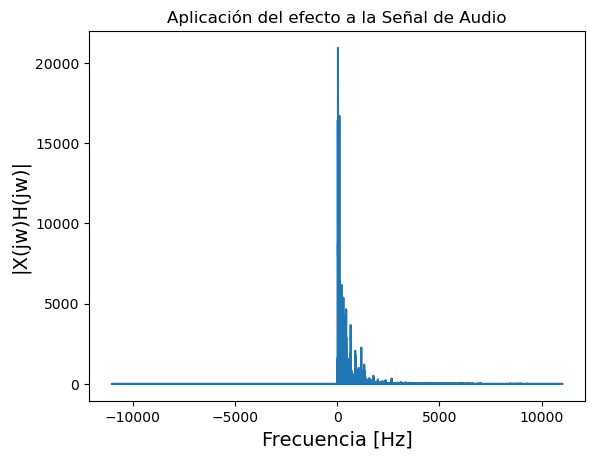

In [32]:
# Tomamos la mitad de los datos para reconstruir el audio
Mag_fil4 = multiplicacion4

for i in range(len(h_rev)//2, len(h_rev)):
    Mag_fil4[i] = 0

reconstruir4 = Mag_fil4
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal de audio con efecto de reverb
plt.plot(vect_frec, abs(Mag_fil4))
plt.title('Aplicación del efecto a la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

En la imagen anterior se aprecia cómo las frecuencias por debajo de aproximadamente los 3KHz se han atenuado, mientras que, por encima de este valor el espectro ha sido eliminado.

Con el siguiente código se aplica la transformada inversa de Fourier a los valores resultantes de la aplicación del efecto a la señal de audio, esta operación nos devuelve una señal que pertenece al dominio del tiempo.

salida= [-0.00030588+0.00033602j -0.00030593+0.00033612j -0.00030596+0.00033621j
 ... -0.0003064 +0.00033584j -0.00030619+0.0003355j
 -0.00030583+0.00033576j]


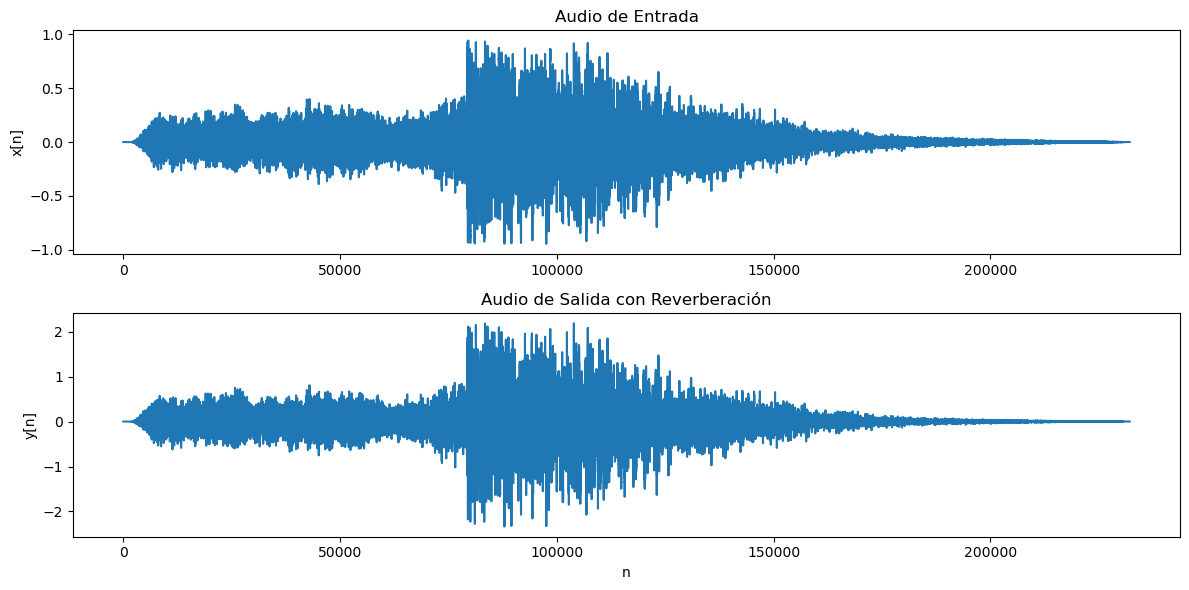

In [33]:
# Aplicación de la Transformada Inversa de Fourier
reconstruir4 = fourier.ifft(reconstruir4)

print(f'salida= {reconstruir4}') # Primeros valores de la respuesta al impulso

# Graficar la señal de entrada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_in)
plt.ylabel('x[n]')
plt.title('Audio de Entrada')

# Graficar la salida con reverberación
plt.subplot(2, 1, 2)
plt.plot(np.real(reconstruir4))
plt.title('Audio de Salida con Reverberación')
plt.xlabel('n')
plt.ylabel('y[n]')
plt.tight_layout()
plt.show()

Las imágenes presentadas previamente (generadas con el código anterior) muestran la distribución y amplitud de los datos de la señal de audio original y de la señal de audio filtrada. En las gráficas se ven notables diferencias en la amplitud y distribución de los datos de las señales. El audio con efecto de reverberación tiene datos con mayor amplitud.

Las diferencias en cuanto a la aplicación del efecto de reverberación no es sencilla de observar con el par de imágenes anterior. Para apreciar de forma clara los cambios que se han hecho en la señal de audio se ha desarrollado el siguiente código que dibuja un espectrograma de la señal de audio con reverberación.

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio con Reverberación')

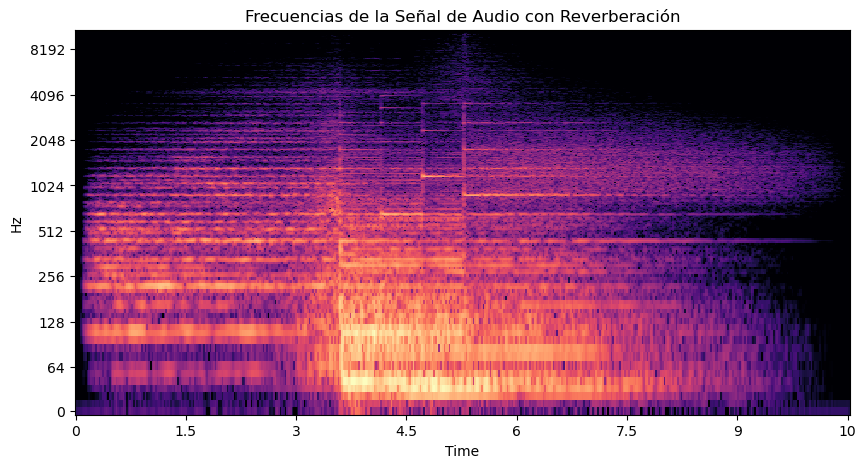

In [34]:
# Graficar el espectro de frecuencias de la señal de audio con reverb
TF_audio4 = librosa.stft(np.real(reconstruir4))
Amp_audio_db4 = librosa.amplitude_to_db(abs(TF_audio4), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db4, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio con Reverberación')

En el espectrograma obtenido existen diferencias notables con respecto al espectrograma de la señal de audio original. El efecto de reverberación a atenuado considerablemente las frecuencias que están aproximadamente por encima de los 3KHz (rango de frecuencias en donde la señal original presenta mayor actividad).

El siguiente código permite reproducir el audio de la señal resultante:

In [35]:
ipd.Audio(np.real(reconstruir4), rate=sr) #Reproducir el audio resultante

2. El efecto de reverberación también se puede aproximar a partir de la expresión de respuesta al impulso h[n]=sin(Wo*n)/πn que corresponde a un filtro paso bajo digital ideal o "brick wall" truncado. La frecuencia Wo es la frecuencia de corte, con la variación de los valores de n en un intervalo cerrado se obtiene un filtro FIR (Finite Impulse Response).

Para construir un vector que forme esta nueva respuesta al impulso se ha desarrollado el siguiente código que evalúa h[n] para una frecuencia de corte de 3500Hz.

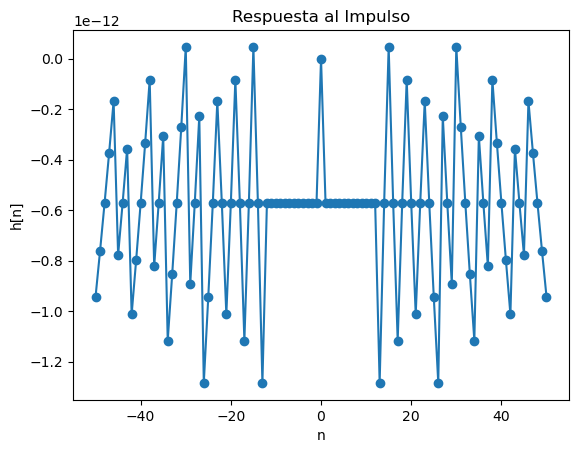

In [36]:
# Generación de la respuesta al impulso del efecto

frec_hz = 3500 # Se define una frecuencia de corte en Hz

fc = frec_hz*2*np.pi # Frecuencia de corte en rad/s

# Crear un array de valores enteros desde -50 a 50
n_1 = np.arange(-50, 0)
n_2 = np.arange(1, 51)
add0 = np.zeros(116013, dtype = int)

# Calcular los valores de la función sin(f*n)/(pi*n)
interv_1 = np.sin(fc * n_1) / (np.pi * n_1)
interv_2 = np.sin(fc * n_2) / (np.pi * n_2)

# Ordenar los valores de la respuesta al impulso
h_n = np.concatenate(([0], add0, interv_1, [0], interv_2, add0), axis=None)

valores = np.concatenate((n_1, [0], n_2), axis=None)

# Graficar los valores de la respuesta al impulso
plt.plot(valores, h_n[116014:116115], marker='o', linestyle='-')
plt.title('Respuesta al Impulso')
plt.xlabel('n')
plt.ylabel('h[n]')
plt.show()

Con el código anterior también se genera una gráfica de la respuesta al impulso del nuevo efecto de reverberación. Con la curva dibujada se ve que la respuesta al impulso presenta oscilaciones debido a la función seno que contiene. Debido a que el denominador de h[n] es πn, los valores de la respuesta al impulso tienden a cero a medida que n crece.

El código a continuación calcula la respuesta en frecuencia de la señal anterior y la representa gráficamente.

H[jw]= [-5.92166308e-11-0.00000000e+00j  5.92166121e-11-1.50080787e-27j
 -5.92165560e-11-1.13132515e-27j ...  5.92164625e-11+1.71241981e-27j
 -5.92165560e-11+1.13132515e-27j  5.92166121e-11+1.50080787e-27j]


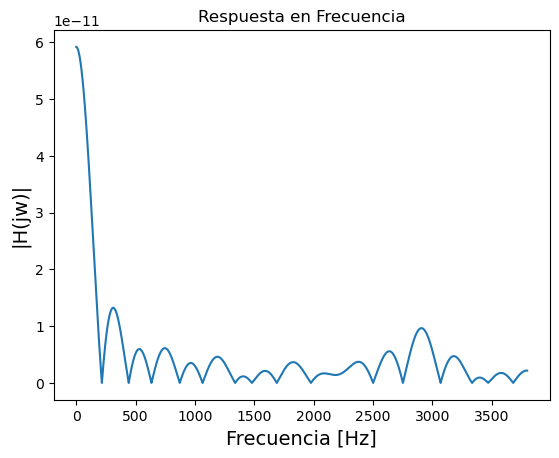

In [37]:
# Cálculo de la respuesta en frecuencia del efecto
H_jw5 = fourier.fft(h_n)

print(f'H[jw]= {H_jw5}') # Primeros valores de la respuesta al impulso

Mag_H_jw5 = abs(H_jw5)

vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la respuesta en frecuencia del efecto
plt.plot(vect_frec[0:40000], Mag_H_jw5[0:40000])
plt.title('Respuesta en Frecuencia')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Los valores de la magnitud de la respuesta en frecuencia del filtro son extremadamente pequeños, esto genera problemas al momento de graficar la señal resultante con el efecto de reverberación.

El código a continuación realiza un escalamiento a las amplitudes de la señal de modo que se obtengan valores más grandes sin afectar la forma de la respuesta en frecuencia.

H[jw]= [-5.92166308-0.00000000e+00j  5.92166121-1.50080787e-16j
 -5.9216556 -1.13132515e-16j ...  5.92164625+1.71241981e-16j
 -5.9216556 +1.13132515e-16j  5.92166121+1.50080787e-16j]


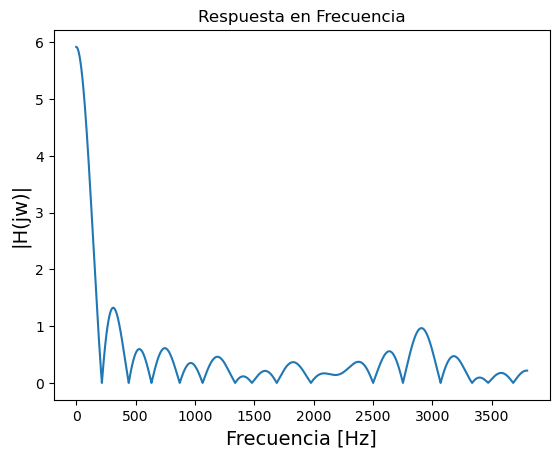

In [38]:
# Escalamiento de la respuesta en frecuencia del efecto
H_jw5 = 100000000000*H_jw5

print(f'H[jw]= {H_jw5}') # Primeros valores de la respuesta al impulso

Mag_H_jw5 = abs(H_jw5)

# Graficar la respuesta en frecuencia del efecto
plt.plot(vect_frec[0:40000], Mag_H_jw5[0:40000])
plt.title('Respuesta en Frecuencia')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|H(jw)|', fontsize='14')
plt.show()

Como se ve en la gráfica anterior, se han cambiado los valores en el orden de 1*10^(-11) por valores en el orden de 1*10^(0). Este cambio no afectó la forma de la respuesta en frecuencia y tampoco altera al audio resultante. 

La respuesta en frecuencia del efecto de reverberación es similar a un filtro, ya que, acentúa las frecuencias que están entre 0 y 400Hz aproximadamente y, por otro lado, atenúa las frecuencias por encima de los 400Hz. Además, por encima de los 3500Hz la amplitud del filtro es muy cercana a cero. Este comportamiento de la respuesta en frecuencia caracteriza al efecto.

Con el bloque de código a continuación se realiza la multiplicación en frecuencia para aplicar el efecto de reverberación al espectro de la señal de audio.

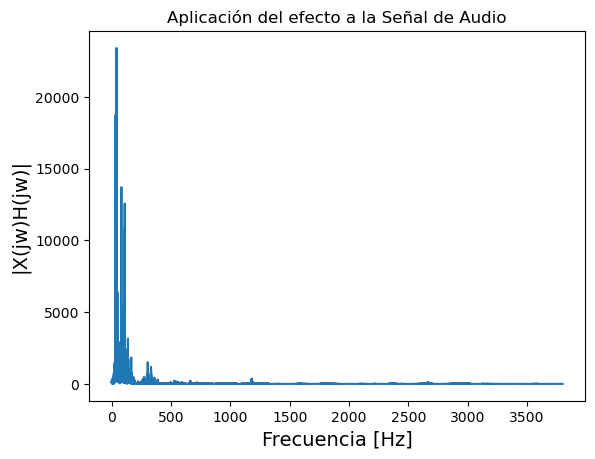

In [39]:
# Multiplicación en frecuencia para aplicar el efecto
multiplicacion5 = TF_entrada*H_jw5

Mag_mult5 = abs(multiplicacion5)
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal con el efecto
plt.plot(vect_frec[0:40000], Mag_mult5[0:40000])
plt.title('Aplicación del efecto a la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

En la gráfica de la señal resultante de la multiplicación en frecuencia se ve que, en efecto, la amplitud del espectro de la señal de audio ha sido modificada, se ha producido una acentuación de los graves y una atenuación de los agudos.

Como se dijo anteriormente, el espectro de frecuencias es simétrico, por lo que debemos considerar únicamente los valores con frecuencias positivas. En el bloque de código a continuación, se extraen únicamente los componentes de frecuencias relacionados a frecuencias positivas y se eliminan las de frecuencias negativas. Además, nuevamente se representa gráficamente a los componentes de frecuencia resultantes del filtrado desde una perspectiva que abarque más frecuencias.

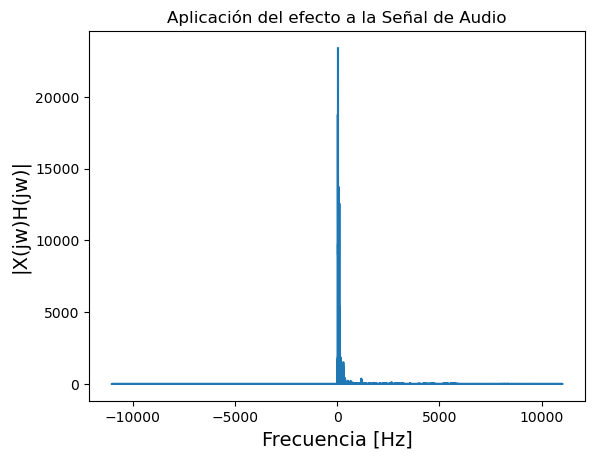

In [40]:
# Tomamos la mitad de los datos para reconstruir la señal
Mag_fil5 = multiplicacion5

for i in range(len(h_n)//2, len(h_n)):
    Mag_fil5[i] = 0

reconstruir5 = Mag_fil5
vect_frec = fourier.fftfreq(len(audio_in), 1/sr)

# Graficar la señal en frecuencia del audio con el efecto
plt.plot(vect_frec, abs(Mag_fil5))
plt.title('Aplicación del efecto a la Señal de Audio')
plt.xlabel('Frecuencia [Hz]', fontsize='14')
plt.ylabel('|X(jw)H(jw)|', fontsize='14')
plt.show()

En la imagen anterior se aprecia cómo las frecuencias bajas son prácticamente las únicas que existen, sin embargo, por debajo de los 5000Hz aún existen componentes espectrales con magnitudes muy pequeñas.

Con el siguiente código se aplica la transformada inversa de Fourier a los valores resultantes de la aplicación del efecto a la señal de audio, esta operación nos devuelve una señal que pertenece al dominio del tiempo.

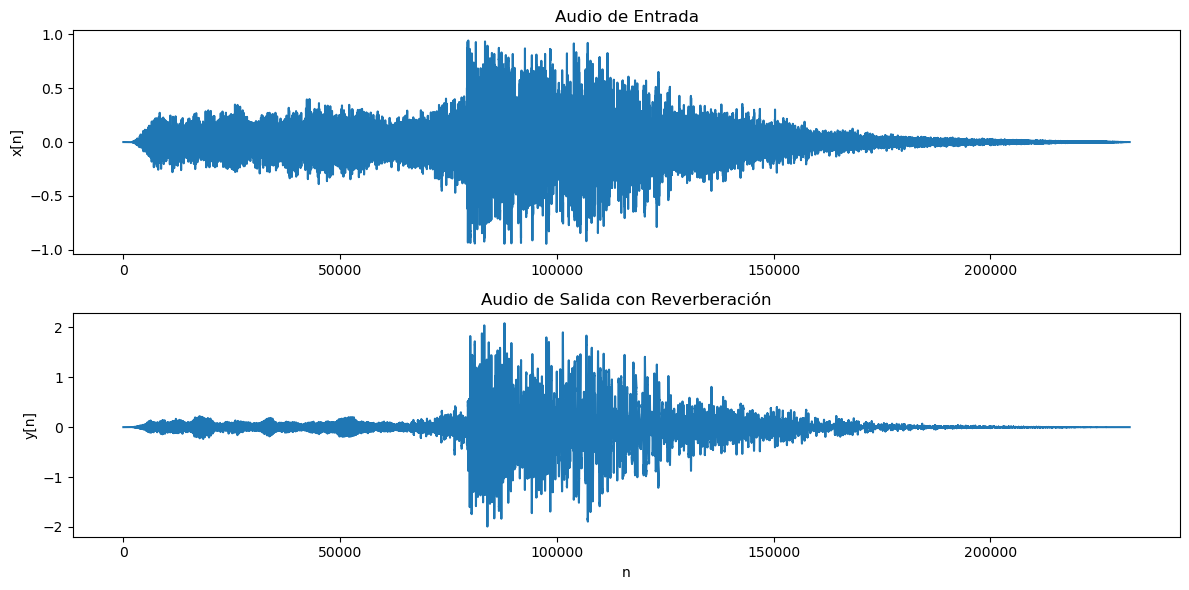

In [41]:
# Aplicar la transformada inversa de Fourier
reconstruir5 = fourier.ifft(reconstruir5)

# Ordenar valores para eliminar desplazamiento
ordx = reconstruir5[len(h_n)//2: len(h_n)]
ordy = reconstruir5[0: len(h_n)//2]

# Multiplicar resultado por 1*10^(10) para evitar datos muy pequeños
# No afecta al resultado final, es útil para graficar la señal
#ordenado5 = 10000000000*np.concatenate((ordx, ordy))
ordenado5 = np.concatenate((ordx, ordy))


# Graficar la señal de entrada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_in)
plt.ylabel('x[n]')
plt.title('Audio de Entrada')

# Graficar la salida con reverberación
plt.subplot(2, 1, 2)
plt.plot(np.real(ordenado5))
plt.title('Audio de Salida con Reverberación')
plt.xlabel('n')
plt.ylabel('y[n]')
plt.tight_layout()
plt.show()

Las imágenes presentadas previamente (generadas con el código anterior) muestran la distribución y amplitud de los datos de la señal de audio original y de la señal de audio filtrada. En las gráficas se ven notables diferencias en la amplitud y distribución de los datos de las señales. El audio con efecto de reverberación tiene datos con mayor amplitud que la señal de audio original.

Las diferencias en cuanto a la aplicación del efecto de reverberación no es sencilla de observar con el par de imágenes anterior. Para apreciar de forma clara los cambios que se han hecho en la señal de audio se ha desarrollado el siguiente código que dibuja un espectrograma de la señal de audio con reverberación.

Text(0.5, 1.0, 'Frecuencias de la Señal de Audio con Reverberación')

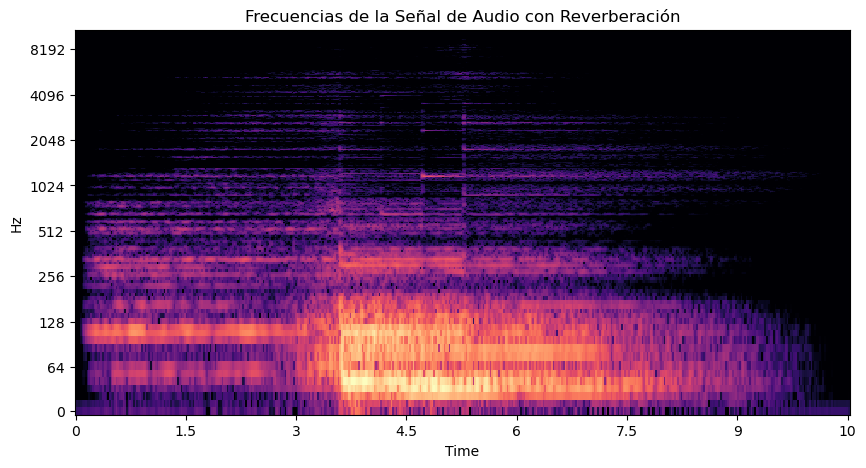

In [42]:
# Graficar el espectro de frecuencias de la señal de audio con reverb
TF_audio5 = librosa.stft(np.real(ordenado5))
Amp_audio_db5 = librosa.amplitude_to_db(abs(TF_audio5), ref=np.max)
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(Amp_audio_db5, x_axis='time', y_axis='log', ax=ax)
plt.title('Frecuencias de la Señal de Audio con Reverberación')

En el espectrograma obtenido se ven grandes diferencias con respecto al espectrograma de la señal de audio original. El efecto de reverberación a atenuado considerablemente las frecuencias que están aproximadamente por encima de los 500Hz. Además, las componentes de frecuencia por encima 2048Hz se han eliminado casi por completo. Este comportamiento ha remarcado los graves del audio y ha debilitado los agudos.

El siguiente código permite reproducir el audio de la señal resultante:

In [43]:
ipd.Audio(np.real(ordenado5), rate=sr) #Reproducir el audio resultante